# Data from Murder Accountability Project II

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from mlxtend.preprocessing import minmax_scaling

from jupyterthemes import jtplot
jtplot.style(figsize=(15, 9))

## Data

In [2]:
map_data = pd.read_csv('data/SHR65_22.csv', index_col=0)
map_data.head()

,CNTYFIPS,Ori,State,Agency,Agentype,Source,Solved,Year,Month,Incident,...,OffRace,OffEthnic,Weapon,Relationship,Circumstance,Subcircum,VicCount,OffCount,FileDate,MSA
ID,,,,,,,,,,,,,,,,,,,,,
197601001AKASP00,"Juneau, AK",AKASP00,Alaska,State Troopers,Primary state LE,FBI,Yes,1976,January,1,...,American Indian or Alaskan Native,Unknown or not reported,Knife or cutting instrument,Husband,Other arguments,NaN,0,0,30180.0,Rural Alaska
197601001AL00102,"Jefferson, AL",AL00102,Alabama,Birmingham,Municipal police,FBI,Yes,1976,January,1,...,Black,Unknown or not reported,Shotgun,Acquaintance,Felon killed by private citizen,Felon killed in commission of a crime,0,0,30180.0,"Birmingham-Hoover, AL"
197601001AL00104,"Jefferson, AL",AL00104,Alabama,Fairfield,Municipal police,FBI,Yes,1976,January,1,...,Black,Unknown or not reported,Shotgun,Wife,Other,NaN,0,0,30180.0,"Birmingham-Hoover, AL"
197601001AL00106,"Jefferson, AL",AL00106,Alabama,Leeds,Municipal police,FBI,Yes,1976,January,1,...,Black,Unknown or not reported,Knife or cutting instrument,Brother,Other arguments,NaN,0,0,30180.0,"Birmingham-Hoover, AL"
197601001AL00201,"Mobile, AL",AL00201,Alabama,Mobile,Municipal police,FBI,Yes,1976,January,1,...,White,Unknown or not reported,Strangulation - hanging,Acquaintance,Circumstances undetermined,NaN,0,0,30180.0,"Mobile, AL"


In [3]:
COLORS = {
    'Sex': ['pink', 'b', 'w'],
    'Solved': ['r', 'b'],
    'Source': ['g', 'b'],
}

## States with big ratio Unsolved/Solved cases

In [24]:
not_solved_cases_by_state = map_data[map_data['Solved']=='No'].groupby('State')\
                                                              .count()\
                                                              .sort_values(by=['CNTYFIPS'],
                                                                           ascending=False)['CNTYFIPS'].to_frame()

solved_cases_by_state = map_data[map_data['Solved']=='Yes'].groupby('State')\
                                                           .count()\
                                                           .sort_values(by=['CNTYFIPS'],
                                                                        ascending=False)['CNTYFIPS']

cases_by_state = not_solved_cases_by_state.merge(solved_cases_by_state, on='State')

cases_by_state.rename(columns={'CNTYFIPS_x': 'Not Solved',
                               'CNTYFIPS_y': 'Solved'}, inplace=True)

cases_by_state['UnSolved/Solved'] = cases_by_state['Not Solved'] / cases_by_state['Solved']
cases_by_state.sort_values(by=['UnSolved/Solved'], ascending=False, inplace=True)

strange_states = cases_by_state[cases_by_state['UnSolved/Solved']>=0.5]
strange_states

,Not Solved,Solved,UnSolved/Solved
State,,,
District of Columbia,5749,3687,1.559262
New York,27649,34379,0.804241
Maryland,9566,13420,0.712817
Illinois,15276,23029,0.663338
California,46897,80704,0.581099
New Jersey,6614,11693,0.565638
Missouri,7708,13999,0.550611
Massachusetts,2842,5171,0.549604


In [33]:
def show_info_about_state(states):
    row = len(states)
    fig, ax = plt.subplots(row, 2, figsize=(21, 13*row))
    for x, state in enumerate(states):
        st = map_data[map_data['State']==state]
        st_status = st.groupby(['Year', 'Solved']).count()['CNTYFIPS'].to_frame()
        st_status = pd.pivot_table(st_status, index='Year', columns='Solved', values='CNTYFIPS')

        st_sex = st.groupby(['Year', 'VicSex']).count()['CNTYFIPS'].to_frame()
        st_sex = pd.pivot_table(st_sex, index='Year', columns='VicSex', values='CNTYFIPS')
        
        st_status.plot(kind='barh', ax=ax[x, y], color=COLORS['Solved']).invert_yaxis()
        ax[x, y].set_title(f'{state} by Case Status')

        st_sex.plot(kind='barh', ax=ax[x, y+1], color=COLORS['Sex']).invert_yaxis()
        ax[x, y+1].set_title(f'{state} by Victims Sex')



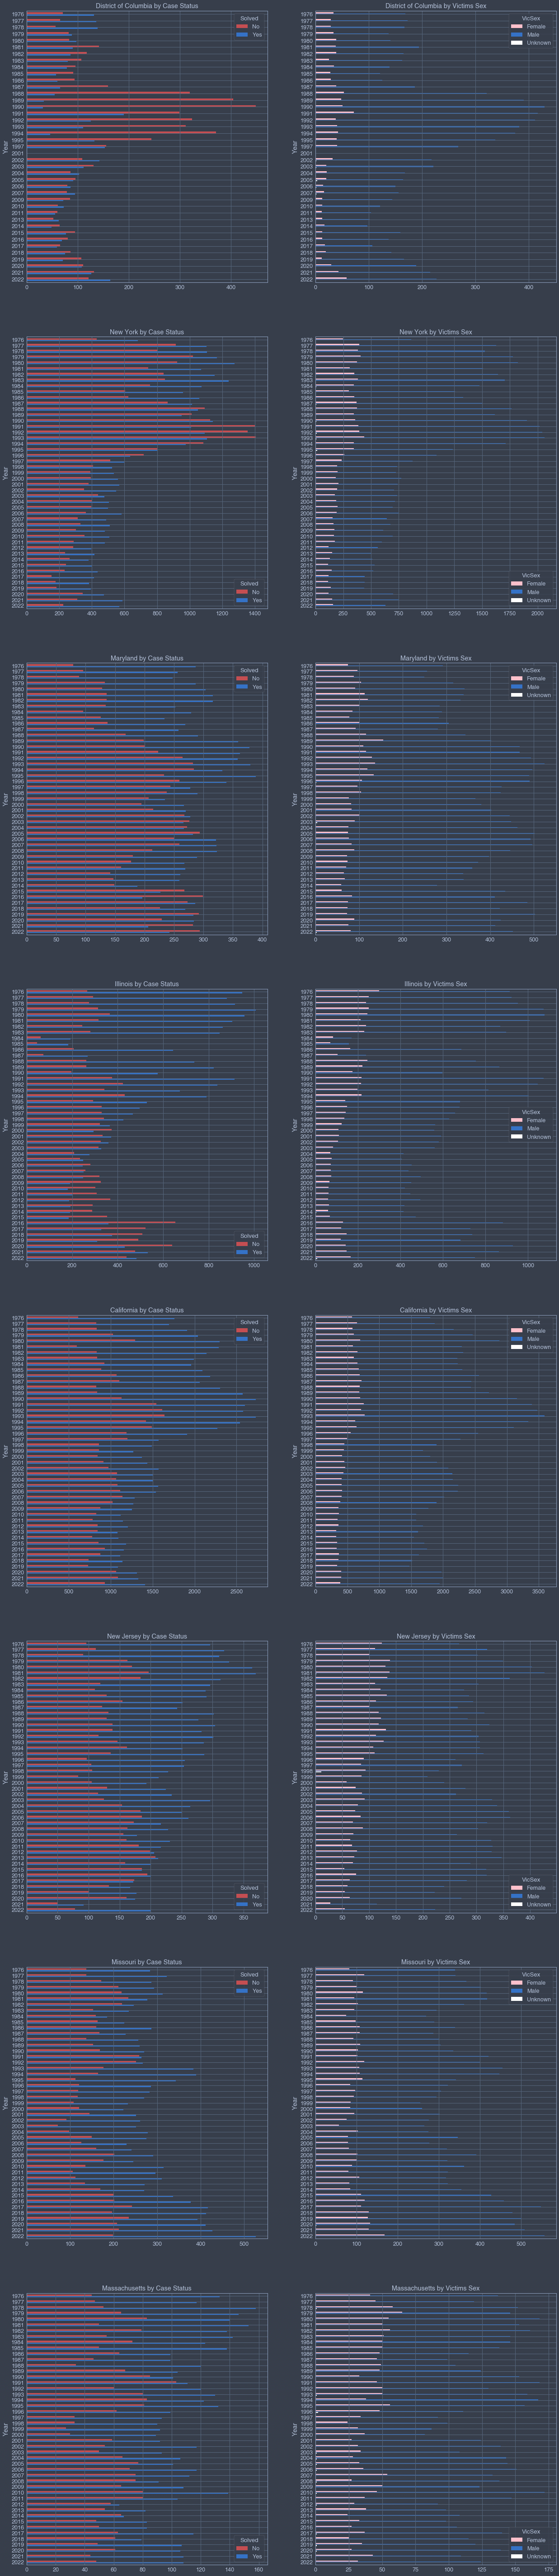

In [34]:
show_info_about_state(strange_states.index.to_list())

## Unsolved cases and weapons

In [19]:
weapon_unslvd = map_data[map_data['Solved']=='No'].groupby(['Weapon', 'VicSex']).count()['CNTYFIPS'].to_frame()
weapon_unslvd = pd.pivot_table(weapon_unslvd, index='Weapon', columns='VicSex', values='CNTYFIPS')
weapon_unslvd.fillna(0, inplace=True)

weapon_unslvd['Female'] = weapon_unslvd['Female'].astype(int)
weapon_unslvd['Male'] = weapon_unslvd['Male'].astype(int)
weapon_unslvd['Unknown'] = weapon_unslvd['Unknown'].astype(int)

weapon_unslvd.sort_values(by=['Male'], ascending=False, inplace=True)

weapon_unslvd

VicSex,Female,Male,Unknown
Weapon,,,
"Handgun - pistol, revolver, etc",11462,119335,159
"Firearm, type not stated",4120,36012,132
Knife or cutting instrument,7206,18188,53
Other or type unknown,6628,11801,447
"Blunt object - hammer, club, etc",3256,7806,20
Shotgun,635,5156,10
"Personal weapons, includes beating",3559,4538,29
Rifle,603,4192,10
Fire,1002,1563,31


In [30]:
weapon_unslvd_min_max = minmax_scaling(weapon_unslvd, columns=weapon_unslvd.columns.to_list())
weapon_unslvd_min_max

VicSex,Female,Male,Unknown
Weapon,,,
"Handgun - pistol, revolver, etc",1.000000,1.000000,0.355705
"Firearm, type not stated",0.358721,0.301649,0.295302
Knife or cutting instrument,0.628264,0.152262,0.118568
Other or type unknown,0.577780,0.098731,1.000000
"Blunt object - hammer, club, etc",0.283256,0.065248,0.044743
Shotgun,0.054328,0.043038,0.022371
"Personal weapons, includes beating",0.309721,0.037858,0.064877
Rifle,0.051533,0.034958,0.022371
Fire,0.086383,0.012924,0.069351


Text(0.5, 1.0, 'Weapons in Unsolved Cases. Min-Max Scalling')

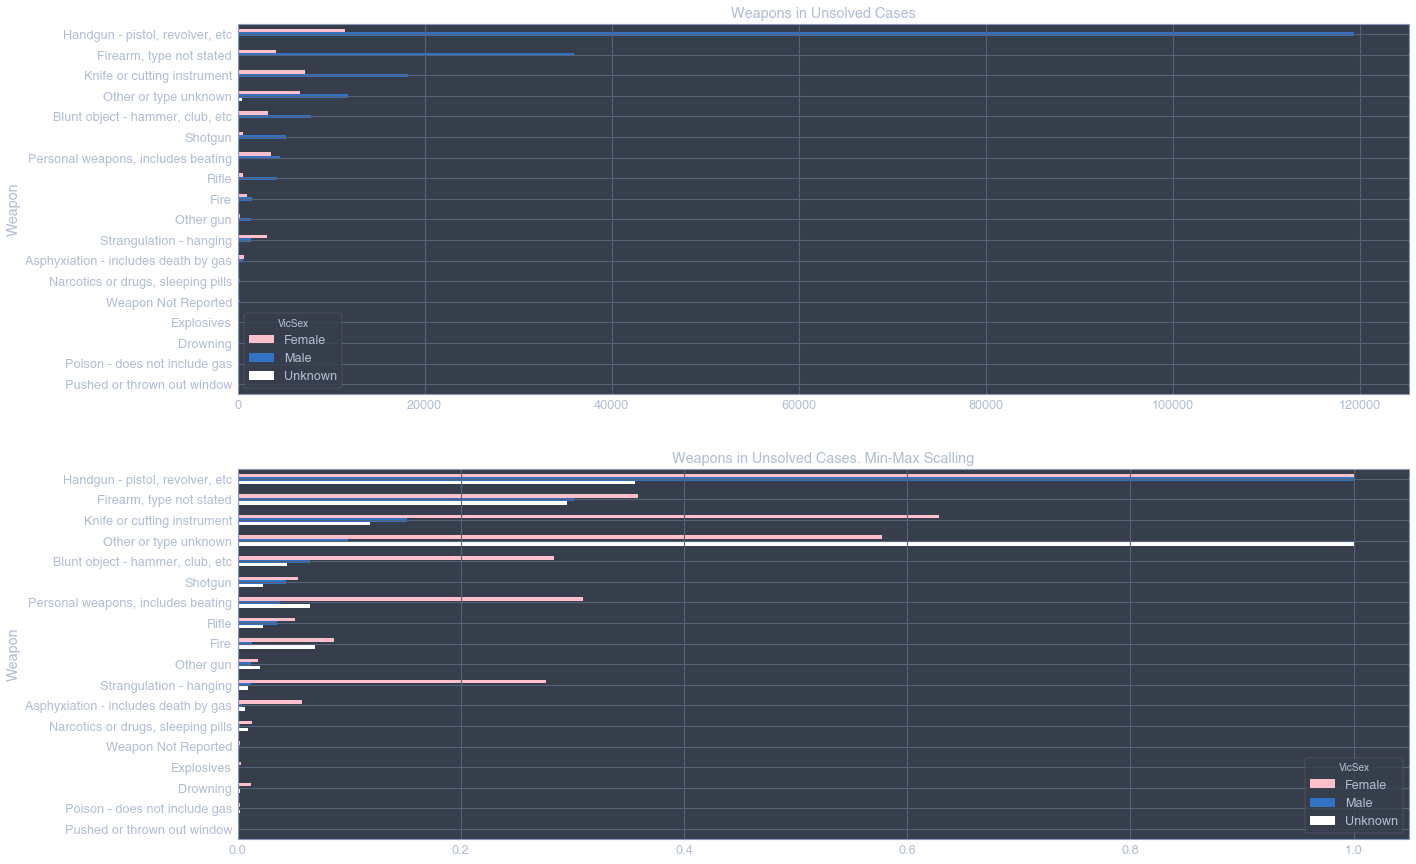

In [32]:
fig, ax = plt.subplots(2, 1, figsize=(21, 15))

weapon_unslvd.plot(kind='barh', ax=ax[0], color=COLORS['Sex']).invert_yaxis()
ax[0].set_title('Weapons in Unsolved Cases')

weapon_unslvd_min_max.plot(kind='barh', ax=ax[1], color=COLORS['Sex']).invert_yaxis()
ax[1].set_title('Weapons in Unsolved Cases. Min-Max Scalling')

### VicSex is Unknown, Not Solved, Weapon is unknown 

In [4]:
unknown = map_data[(map_data['Solved']=='No')
                   & (map_data['Weapon']=='Other or type unknown')
                   & (map_data['VicSex']=='Unknown')]
unknown.head()

,CNTYFIPS,Ori,State,Agency,Agentype,Source,Solved,Year,Month,Incident,...,OffRace,OffEthnic,Weapon,Relationship,Circumstance,Subcircum,VicCount,OffCount,FileDate,MSA
ID,,,,,,,,,,,,,,,,,,,,,
197612002OK00801,"Caddo, OK",OK00801,Oklahoma,Anadarko,Municipal police,FBI,No,1976,December,2,...,Unknown,Unknown or not reported,Other or type unknown,Relationship not determined,Other,NaN,0,0,30180.0,Rural Oklahoma
197612003OK00801,"Caddo, OK",OK00801,Oklahoma,Anadarko,Municipal police,FBI,No,1976,December,3,...,Unknown,Unknown or not reported,Other or type unknown,Relationship not determined,Other,NaN,0,0,30180.0,Rural Oklahoma
197703006TX10100,"Harris, TX",TX10100,Texas,Harris County,Sheriff,FBI,No,1977,March,6,...,Unknown,Unknown or not reported,Other or type unknown,Relationship not determined,Circumstances undetermined,NaN,0,0,30180.0,"Houston-Sugar Land-Baytown, TX"
197704001TX21800,"Sutton, TX",TX21800,Texas,Sutton County,Sheriff,FBI,No,1977,April,1,...,Unknown,Unknown or not reported,Other or type unknown,Relationship not determined,Circumstances undetermined,NaN,0,0,30180.0,Rural Texas
197705004FL01300,"Miami-Dade, FL",FL01300,Florida,Miami-Dade,County police,FBI,No,1977,May,4,...,Unknown,Unknown or not reported,Other or type unknown,Relationship not determined,All suspected felony type,NaN,0,0,30180.0,"Miami-Fort Lauderdale, FL"


In [5]:
unknown_by_state = unknown.groupby('State').count().sort_values(by=['CNTYFIPS'], ascending=True)['CNTYFIPS']
unknown_by_year = unknown.groupby('Year').count()['CNTYFIPS']

Text(0.5, 1.0, 'Weapon, VicSex are Unknown, Case is Unsolved')

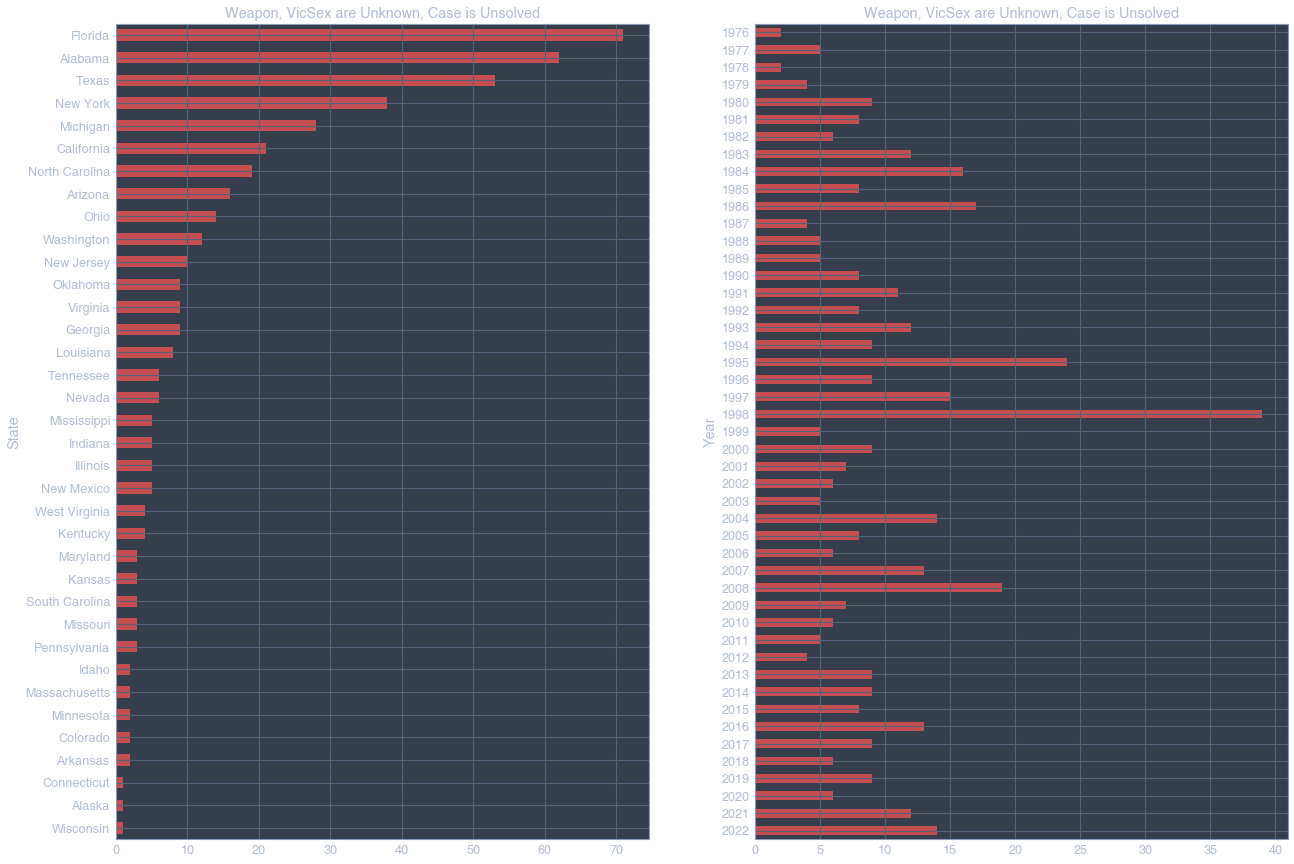

In [41]:
fig, ax = plt.subplots(1, 2, figsize=(21, 15))

unknown_by_state.plot(kind='barh', ax=ax[0], color='r')
ax[0].set_title('Weapon, VicSex are Unknown, Case is Unsolved')

unknown_by_year.plot(kind='barh', ax=ax[1], color='r').invert_yaxis()
ax[1].set_title('Weapon, VicSex are Unknown, Case is Unsolved')

In [29]:
unknown[unknown['Year']==1995].groupby('State').count()

,CNTYFIPS,Ori,Agency,Agentype,Source,Solved,Year,Month,Incident,ActionType,...,OffRace,OffEthnic,Weapon,Relationship,Circumstance,Subcircum,VicCount,OffCount,FileDate,MSA
State,,,,,,,,,,,,,,,,,,,,,
Alabama,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,0,2,2,2,2
Arizona,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,0,1,1,1,1
California,4,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,0,4,4,4,4
Louisiana,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,0,1,1,1,1
New York,13,13,13,13,13,13,13,13,13,13,...,13,13,13,13,13,0,13,13,13,13
North Carolina,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,0,1,1,1,1
Pennsylvania,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,0,1,1,1,1
Texas,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,0,1,1,1,1


In [8]:
unknown[unknown['Year']==1998].groupby('State').count()

,CNTYFIPS,Ori,Agency,Agentype,Source,Solved,Year,Month,Incident,ActionType,...,OffRace,OffEthnic,Weapon,Relationship,Circumstance,Subcircum,VicCount,OffCount,FileDate,MSA
State,,,,,,,,,,,,,,,,,,,,,
Alabama,36,36,36,36,36,36,36,36,36,36,...,36,36,36,36,36,0,36,36,36,36
Florida,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,0,1,1,1,1
Michigan,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,0,1,1,1,1
Virginia,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,0,1,1,1,1


In [11]:
unknown[unknown['State']=='Alabama'].groupby('Year').count()

,CNTYFIPS,Ori,State,Agency,Agentype,Source,Solved,Month,Incident,ActionType,...,OffRace,OffEthnic,Weapon,Relationship,Circumstance,Subcircum,VicCount,OffCount,FileDate,MSA
Year,,,,,,,,,,,,,,,,,,,,,
1992,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,0,2,2,2,2
1993,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,0,1,1,1,1
1994,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,0,1,1,1,1
1995,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,0,2,2,2,2
1996,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,0,1,1,1,1
1997,12,12,12,12,12,12,12,12,12,12,...,12,12,12,12,12,0,12,12,12,12
1998,36,36,36,36,36,36,36,36,36,36,...,36,36,36,36,36,0,36,36,36,36
2013,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,0,1,1,1,1
2014,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,0,1,1,1,1


In [18]:
unknown[(unknown['State']=='Alabama') & (unknown['Year'].isin([1997, 1998]))].groupby('CNTYFIPS').count()

,Ori,State,Agency,Agentype,Source,Solved,Year,Month,Incident,ActionType,...,OffRace,OffEthnic,Weapon,Relationship,Circumstance,Subcircum,VicCount,OffCount,FileDate,MSA
CNTYFIPS,,,,,,,,,,,,,,,,,,,,,
"Etowah, AL",2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,0,2,2,2,2
"Jefferson, AL",40,40,40,40,40,40,40,40,40,40,...,40,40,40,40,40,0,40,40,40,40
"Lee, AL",2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,0,2,2,2,2
"Mobile, AL",2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,0,2,2,2,2
"Montgomery, AL",1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,0,1,1,1,1
"Randolph, AL",1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,0,1,1,1,1


In [32]:
unknown[(unknown['State']=='Alabama')
        & (unknown['Year'].isin([1997, 1998]))
        & (unknown['CNTYFIPS']=='Jefferson, AL')][['Month', 'Incident']].groupby('Month').count()

,Incident
Month,
April,2
August,6
December,3
February,2
January,2
July,3
June,3
March,2
May,3


In [31]:
unknown[(unknown['State']=='Alabama')
        & (unknown['Year'].isin([1997, 1998]))
        & (unknown['CNTYFIPS']=='Jefferson, AL')][['Month', 'Incident']].groupby('Month').count().describe()

,Incident
count,12.000000
mean,3.333333
std,2.386833
min,2.000000
25%,2.000000
50%,2.500000
75%,3.000000
max,10.000000


In [38]:
unknown[unknown['State']=='Florida'].groupby('Year').count().quantile(q=.75)[0]

3.0